# Predicting Poverty
This notebook contains my analysis for the DrivenData.org 'Pover-T Tests: Predicting Poverty' competition.

# Problem Description
This is taken from the DrivenData competition webpage.

"Your models should predict whether or not a given household for a given country is poor or not. The training features are survey data from three countries. For each country, A, B, and C, survey data is provided at the household as well as individual level. Each household is identified by its id, and each individual is identified by both their household id and individual iid. Most households have multiple individuals that make up that household."

In [20]:
# Import modules

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
%matplotlib inline

# Load the training and test data into data frames
## Training
A_hhold_train_df = pd.read_csv("A_hhold_train.csv")
B_hhold_train_df = pd.read_csv("B_hhold_train.csv")
C_hhold_train_df = pd.read_csv("C_hhold_train.csv")
A_indiv_train_df = pd.read_csv("A_indiv_train.csv")
B_indiv_train_df = pd.read_csv("B_indiv_train.csv")
C_indiv_train_df = pd.read_csv("C_indiv_train.csv")
A_merge_train_df = pd.merge(A_hhold_train_df, A_indiv_train_df, on='id')
B_merge_train_df = pd.merge(B_hhold_train_df, B_indiv_train_df, on='id')
C_merge_train_df = pd.merge(C_hhold_train_df, C_indiv_train_df, on='id')

## Test
A_hhold_test_df = pd.read_csv("A_hhold_test.csv")
B_hhold_test_df = pd.read_csv("B_hhold_test.csv")
C_hhold_test_df = pd.read_csv("C_hhold_test.csv")
A_indiv_test_df = pd.read_csv("A_indiv_test.csv")
B_indiv_test_df = pd.read_csv("B_indiv_test.csv")
C_indiv_test_df = pd.read_csv("C_indiv_test.csv")
A_merge_test_df = pd.merge(A_hhold_test_df, A_indiv_test_df, on='id')
B_merge_test_df = pd.merge(B_hhold_test_df, B_indiv_test_df, on='id')
C_merge_test_df = pd.merge(C_hhold_test_df, C_indiv_test_df, on='id')

# Initial look at the data
The competition page provides a general explanation of the data but it would be useful to explore the data a bit first. Particularly, it would be good to see if there's any differences between the three countries A, B, and C, for both the household and individual data sets.

## Data format
Each column of data represents a survey question which is either multiple choice, where the response has been encoded as a random string, or it's a numeric value. Examples of questions are: "Does your household have items such as bar soap, cooking oil, matches, and salt?", "How many working cell phones in total does your household own?"

In [2]:
A_hhold_train_df.head()

,id,wBXbHZmp,SlDKnCuu,KAJOWiiw,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,maLAYXwi,vwpsXRGk,...,sDGibZrP,CsGvKKBJ,OLpGAaEu,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ,country
0,46107,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,XAmOF,...,JqHnW,MaXfS,etZsD,idRwx,LPtkN,vkbkA,qQxrL,AITFl,aQeIm,A
1,82739,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,lwCkE,...,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
2,9646,JhtDR,GUusz,BIZns,ZYabk,uxuSS,PHMVg,NDTCU,sehIp,qNABl,...,JqHnW,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
3,10975,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,sPNOc,...,JqHnW,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
4,16463,JhtDR,alLXR,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,NdlDR,...,JqHnW,MaXfS,etZsD,idRwx,UyAms,vkbkA,qQxrL,GAZGl,aQeIm,A


In [3]:
A_hhold_train_df.describe()

,id,nEsgxvAq,OMtioXZZ,YFMZwKrU,TiwRslOh
count,8203.000000,8203.000000,8203.000000,8203.000000,8203.000000
mean,49672.317689,-7.590638,17.464464,-2.985615,-4.191028
std,28799.840963,5.810942,10.853654,0.896245,4.472567
min,14.000000,-70.000000,-127.000000,-4.000000,-31.000000
25%,24871.500000,-10.000000,12.000000,-4.000000,-7.000000
50%,49422.000000,-4.000000,12.000000,-3.000000,-3.000000
75%,74074.000000,-4.000000,21.000000,-2.000000,-1.000000
max,99965.000000,-4.000000,111.000000,1.000000,3.000000


In [4]:
A_hhold_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8203 entries, 0 to 8202
Columns: 346 entries, id to country
dtypes: bool(1), float64(2), int64(3), object(340)
memory usage: 21.6+ MB


In [5]:
A_hhold_train_df.describe(include=['O'])

,wBXbHZmp,SlDKnCuu,KAJOWiiw,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,maLAYXwi,vwpsXRGk,sArDRIyX,...,sDGibZrP,CsGvKKBJ,OLpGAaEu,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ,country
count,8203,8203,8203,8203,8203,8203,8203,8203,8203,8203,...,8203,8203,8203,8203,8203,8203,8203,8203,8203,8203
unique,2,2,3,2,2,2,2,3,31,2,...,2,2,3,2,2,2,2,2,2,1
top,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,sPNOc,MwLvg,...,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
freq,8095,6015,5252,7728,7560,7797,6928,6860,398,8139,...,8196,7173,3640,7943,6199,8097,8141,7383,5433,8203


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff370003b50>]], dtype=object)

/home/alex/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


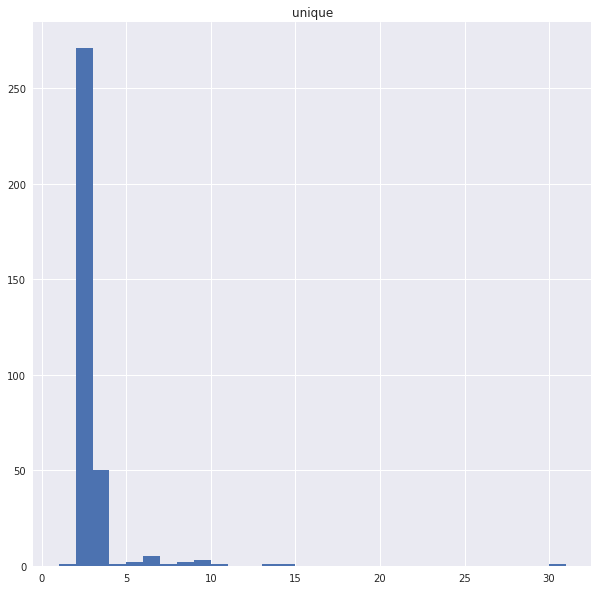

In [6]:
# Look at how many answers a typical multiple choice question has
A_hhold_unique = A_hhold_train_df.describe(include=['O']).iloc[[1]]
A_hhold_unique.transpose().astype(str).astype(int).hist(bins=30, figsize=(10,10))

## Initial insight
By looking at A_hhold_train_df, it can be seen that there are 4 columns excluding 'id' with numeric values (2 with floats, 2 with integers). There's the 'poor' column which is a bool and the rest are random strings from multiple choice questions.

Additionally, it can be seen that the multiple choice questions typically have 2 options which I would guess are "yes" and "no". It's interesting to see that there's at least one question with 30 answers.

## Things to do
* Convert multiple choice answers into dummy variables for logistic regression
* Examine individual dataset

In [7]:
A_hhold_train_df.select_dtypes(include=['object'])

,wBXbHZmp,SlDKnCuu,KAJOWiiw,DsKacCdL,rtPrBBPl,tMJrvvut,jdetlNNF,maLAYXwi,vwpsXRGk,sArDRIyX,...,sDGibZrP,CsGvKKBJ,OLpGAaEu,LrDrWRjC,JCDeZBXq,HGPWuGlV,GDUPaBQs,WuwrCsIY,AlDbXTlZ,country
0,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,XAmOF,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,LPtkN,vkbkA,qQxrL,AITFl,aQeIm,A
1,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,lwCkE,MwLvg,...,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
2,JhtDR,GUusz,BIZns,ZYabk,uxuSS,PHMVg,NDTCU,sehIp,qNABl,MwLvg,...,JqHnW,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
3,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,sehIp,sPNOc,MwLvg,...,JqHnW,MaXfS,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
4,JhtDR,alLXR,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,NdlDR,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,UyAms,vkbkA,qQxrL,GAZGl,aQeIm,A
5,JhtDR,alLXR,BIZns,ZYabk,feupP,PHMVg,NDTCU,sehIp,bUhyU,MwLvg,...,JqHnW,MaXfS,HxnJy,idRwx,UyAms,vkbkA,qQxrL,AITFl,aQeIm,A
6,JhtDR,GUusz,BIZns,ZYabk,feupP,PHMVg,PUBDZ,cLAGr,esAQH,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
7,JhtDR,GUusz,BIZns,ZYabk,feupP,PHMVg,NDTCU,sehIp,vVbnO,MwLvg,...,JqHnW,jkHEU,USRak,idRwx,UyAms,vkbkA,qQxrL,AITFl,cecIq,A
8,JhtDR,GUusz,BIZns,ZYabk,feupP,PHMVg,NDTCU,sehIp,yKWYC,MwLvg,...,JqHnW,MaXfS,USRak,idRwx,LPtkN,vkbkA,qQxrL,AITFl,cecIq,A
9,JhtDR,GUusz,TuovO,ZYabk,feupP,PHMVg,NDTCU,cLAGr,RpXJc,MwLvg,...,JqHnW,MaXfS,etZsD,idRwx,UyAms,vkbkA,qQxrL,AITFl,aQeIm,A


In [8]:
A_hhold_train_dum = pd.get_dummies(A_hhold_train_df)
A_hhold_test_dum = pd.get_dummies(A_hhold_test_df)

In [9]:
A_hhold_train_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8203 entries, 0 to 8202
Columns: 861 entries, id to country_A
dtypes: bool(1), float64(2), int64(3), uint8(855)
memory usage: 7.0 MB


# Attempt Logistic Regression
The data for the A househould training set has been made into a usable data frame. This now needs to be split into the X and y components and given to a logistic regression.

In [10]:
X_A_hhold_train, X_A_hhold_val, y_A_hhold_train, y_A_hhold_val = train_test_split(A_hhold_train_dum.drop(['poor'], axis=1), 
                                                                                  A_hhold_train_dum['poor'], test_size=0.4,
                                                                                  random_state=0)

In [11]:
X_A_hhold_train.shape, y_A_hhold_train.shape, X_A_hhold_val.shape, y_A_hhold_val.shape

((4921, 860), (4921,), (3282, 860), (3282,))

In [12]:
logit = linear_model.LogisticRegression()
logit_model = logit.fit(X_A_hhold_train, y_A_hhold_train)

In [13]:
logit_model.score(X_A_hhold_val, y_A_hhold_val)

0.84582571602681289

I broke the training set data into 2 pieces: a training set of 60% and a validation set of 40%. This allows me to train on a portion of the data and then check my performance on untrained data that I know the answer to. Using just the A_hhold I managed to predict with an accuracy of 84.6% whether an entry was poor in the validation set.

The next step is to expand this to a larger training set containing all of the household data. I'd like to submit once using just household information to see how well I perform. I would then like to merge the household and individual data together and create a new model with this information.

In [14]:
B_hhold_train_dum = pd.get_dummies(B_hhold_train_df)
B_hhold_test_dum = pd.get_dummies(B_hhold_test_df)
C_hhold_train_dum = pd.get_dummies(C_hhold_train_df)
C_hhold_test_dum = pd.get_dummies(C_hhold_test_df)

In [15]:
hhold_train_dum = pd.concat([A_hhold_train_dum, B_hhold_train_dum, C_hhold_train_dum])
X_hhold_train, X_hhold_val, y_hhold_train, y_hhold_val = train_test_split(hhold_train_dum.drop(['poor'], axis=1),
                                                                         hhold_train_dum['poor'], test_size=0.4,
                                                                         random_state=0)

In [16]:
logit_hhold = logit.fit(X_hhold_train, y_hhold_train)
logit_hhold.score(X_hhold_val, y_hhold_val)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Finding a problem in the setup
I attempted to repeat for B and C countries what I did for A, however, I discovered that I had a NaN, infinity, or too large of a value which caused my fit to fail.

In [ ]:
# Quick check to see if there are any NaN
B_hhold_train_dum.isnull().values.any()

In [ ]:
# More detail for NaN
B_hhold_train_dum.isnull().sum().sum()

In [ ]:
B_hhold_train_df.select_dtypes(include=['float64'])

# Update on tasks
- How does logit handle continuous and categorical data at the same time?
- I should normalize features if possible

In [35]:
#X_train, X_val, y_train, y_val = train_test_split(A_hhold_train_df.drop(['poor'], axis=1), 
#                                                  A_hhold_train_df['poor'], test_size=0.4,
#                                                  random_state=0)
#logit_model = logit.fit(X_train, y_train)
#logit_model.score(X_val, y_val)

#A_hhold_train_df.select_dtypes(include=['float64']).head()
df_check = A_hhold_train_df
rs = RobustScaler().fit_transform(A_hhold_train_df.select_dtypes(include=['float64']))
rs_df = pd.DataFrame(rs, index=df_check.index.values)
to_drop = df_check.select_dtypes(include=['float64']).columns.values
df_check.drop(to_drop, axis=1)
df_check = pd.merge(df_check, rs_df, on='id')
df_check.select_dtypes(include=['float64']).head()

KeyError: 'id'